In [2]:
%load_ext autoreload
%autoreload 2
filename = "scale-nop.csv"
import seaborn as sns
sns.set_style("darkgrid")
sns.set_palette("tab10")

import warnings
warnings.filterwarnings('ignore')

In [2]:
from viz import load_and_save_hivemind_runs_nop
load_and_save_hivemind_runs_nop(filename)

scanning run 3u30jlux
scanning run 2hspllhx
scanning run 1cyqwmj6
scanning run lh9wkvm6
scanning run 7fhpf62x
scanning run 5b5hyer0
scanning run 3ui9f5te
scanning run 3oaxuohc
scanning run 3mpg63xi
scanning run 34r9vyj3
scanning run 3335pix7
scanning run 22buonsy
scanning run 1ztar2n5
scanning run 1u3eg1le
scanning run 1c17zi4m
scanning run 14grma5l
scanning run x8qisvtv
scanning run 3p0kwc26
scanning run 305s1835
scanning run 2w85d8yg
scanning run 2u7geke5
scanning run 2jysroae
scanning run 1uqgayn1
scanning run 1nv94ok8
scanning run 18msz4fq
scanning run 17fkihom
scanning run 12whgq5u
scanning run dflfgc94
scanning run crrrwwk4
scanning run 3zacnnyc
scanning run 2nig3oip
scanning run 2m878p9c
scanning run 3e3bzdmd
scanning run 1t26tw32
scanning run u02cmj5r
scanning run tkl4g8jo
scanning run 7lxmusre
scanning run 3lc1hjxg
scanning run 3kega56w
scanning run 3gdp6m6d
scanning run 2rhl3zd9
scanning run 1wkd4iox
scanning run 1s6goom4
scanning run 1juq2w36
scanning run 1hx1lym2
scanning r

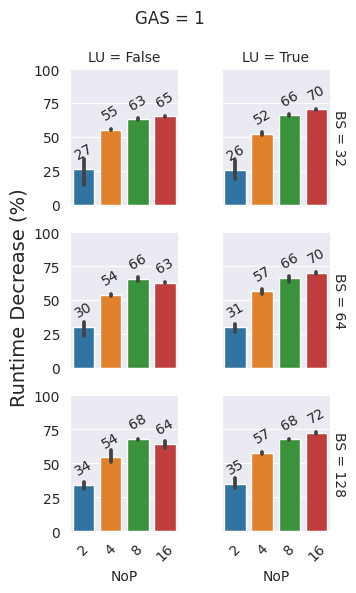

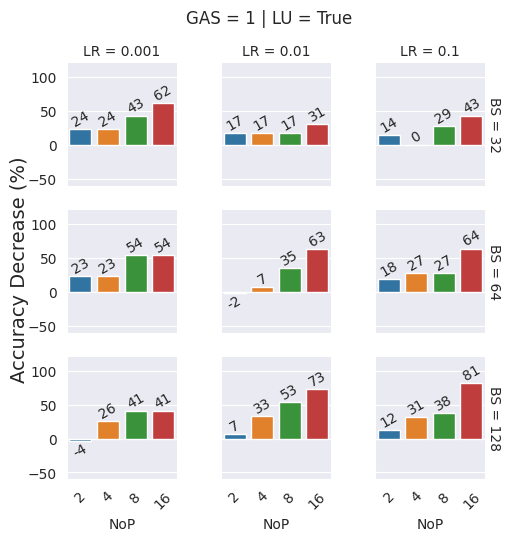

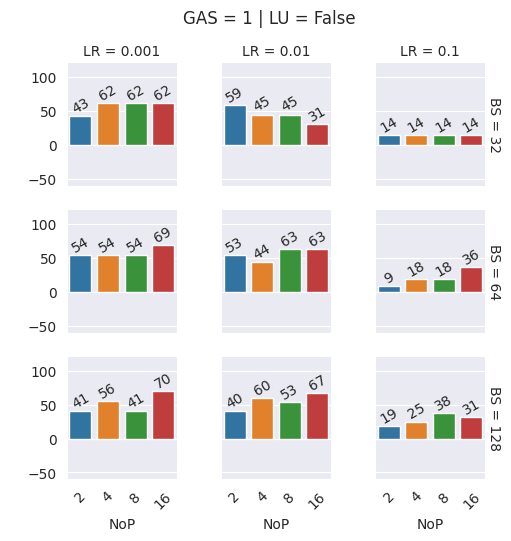

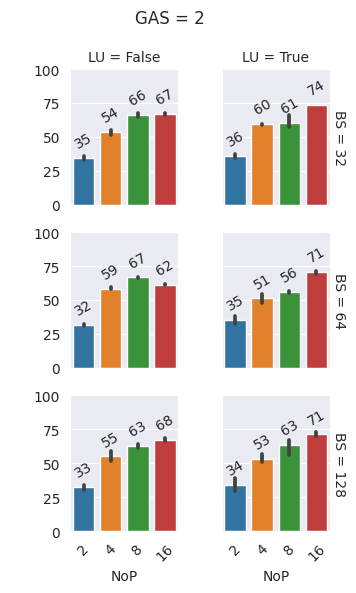

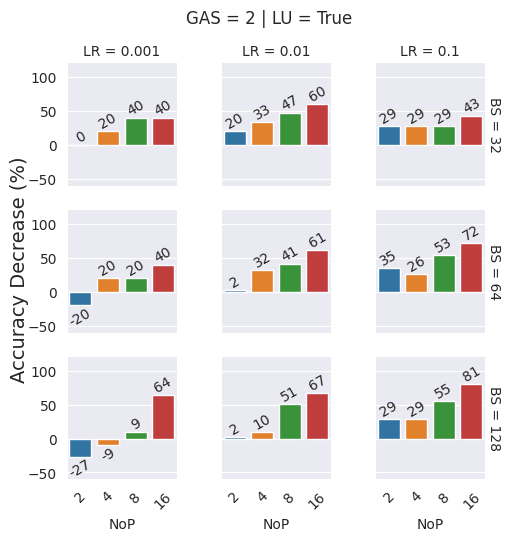

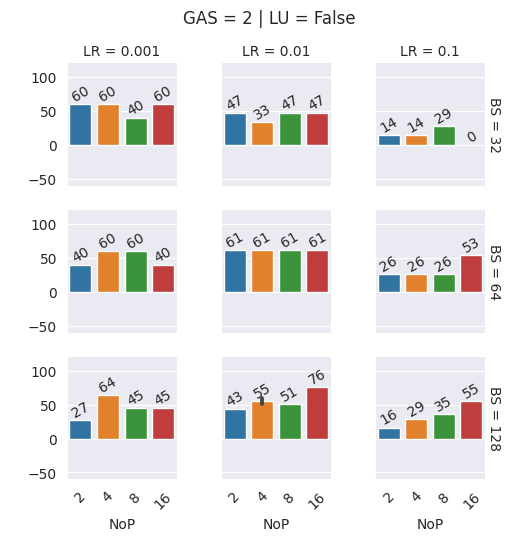

In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from viz import load_baseline_data, find_baseline, print_increase_info, calc_increase_info

group_by = ["number_of_nodes", "batch_size_per_step", "optimizer_params.lr", "gradient_accumulation_steps", "use_local_updates", "run_name"]
ascending = [True, False, True, True, True, False]

describe_cols = ["_runtime", "train/samples_ps", "train/accuracy", "train/model_forward_s", "train/model_backward_only_s", "train/model_opt_s"]

summary_data = pd.read_csv(os.path.abspath('') + f"/summary-{filename}", usecols=[*group_by, *describe_cols])
baseline_data = load_baseline_data()

summary_data = summary_data.groupby(by=group_by)[describe_cols].describe().reset_index()
summary_data["_runtime_max"] = summary_data["_runtime"]["max"]

def calculate_runtime_decrease(row):
    baseline_run = find_baseline(baseline_data, row["batch_size_per_step"].item(), row["optimizer_params.lr"].item(), row["gradient_accumulation_steps"].item())
    if baseline_run is not None:
        increase_value, increase_sign, increase_color = calc_increase_info(row["_runtime_max"].item(), baseline_run["_runtime"]["mean"], sign=-1)
        return increase_value * (-1 if increase_sign == "-" else 1)
    return 0

def calculate_accuracy_decrease(row):
    baseline_run = find_baseline(baseline_data, row["batch_size_per_step"].item(), row["optimizer_params.lr"].item(), row["gradient_accumulation_steps"].item())

    if baseline_run is not None:
        increase_value, increase_sign, increase_color = calc_increase_info(row["train/accuracy"]["max"], baseline_run["train/accuracy"]["mean"], sign=-1)
        # if row["number_of_nodes"].item() == 2 and row["use_local_updates"].item() == True and row["gradient_accumulation_steps"].item() == 2 and row["batch_size_per_step"].item() == 64 and row["optimizer_params.lr"].item() == 0.001:
        #     print(row)
            # print(baseline_run)
            # print(increase_value, increase_sign, increase_color)
        return increase_value * (-1 if increase_sign == "-" else 1)
    return 0

summary_data["runtime_decrease"] = summary_data.apply(calculate_runtime_decrease, axis=1)
summary_data["accuracy_decrease"] = summary_data.apply(calculate_accuracy_decrease, axis=1)
summary_data = summary_data.sort_values(group_by, ascending=ascending).reset_index(drop=True)

for gas in [1, 2]:
    data_gas = summary_data[summary_data["gradient_accumulation_steps"] == gas]

    g1 = sns.FacetGrid(data_gas, row="batch_size_per_step", col="use_local_updates", height=2, margin_titles=True, gridspec_kws={"wspace": 0.4, "hspace": 0.2})
    g1.figure.suptitle(f"GAS = {gas}")
    g1.set_xticklabels(rotation=45)

    g2 = g1.map_dataframe(sns.barplot, x="number_of_nodes", y="runtime_decrease", dodge=False, order=data_gas["number_of_nodes"].unique(), palette="tab10")
    for axlist in g2.axes:
        for ax in axlist:
            for i in ax.containers:
                ax.bar_label(i, fmt="%.0f", rotation=30, padding=5)

    g1.set_titles(row_template="BS = {row_name}", col_template="LU = {col_name}")
    g1.set_xlabels("NoP")
    g1.set_ylabels("")
    g1.set(ylim=(0, 100))
    g1.figure.subplots_adjust(left=0.25)
    if gas == 1:
        g1.figure.supylabel("Runtime Decrease (%)", x=0.1, fontsize=14)
    if gas == 2:
        g1.figure.supylabel(" ", x=0.1, fontsize=14)
    g1.figure.savefig(f"../../figures/06_barplot-runtime_gas-{gas}_{filename.replace('.csv', '.pdf')}")
    plt.show()

    for use_local_updates in [True, False]:
        data_gas_ulu = data_gas[data_gas["use_local_updates"] == use_local_updates]

        g1 = sns.FacetGrid(data_gas_ulu, row="batch_size_per_step", col="optimizer_params.lr", height=1.8, margin_titles=True, gridspec_kws={"wspace":0.4})
        g1.figure.suptitle(f"GAS = {gas} | LU = {use_local_updates}")
        g1.set_xticklabels(rotation=45)
        g2 = g1.map_dataframe(sns.barplot, x="number_of_nodes", y="accuracy_decrease", dodge=False, order=data_gas_ulu["number_of_nodes"].unique(), palette="tab10")
        for axlist in g2.axes:
            for ax in axlist:
                for i in ax.containers:
                    ax.bar_label(i, fmt="%.0f", rotation=30)

        g1.set_titles(row_template="BS = {row_name}", col_template="LR = {col_name}")
        g1.set_xlabels("NoP")
        g1.set_ylabels("")
        g1.set(ylim=(-60, 120))
        if use_local_updates:
            g1.figure.supylabel("Accuracy Decrease (%)", fontsize=14)
        if not use_local_updates:
            g1.figure.supylabel(" ", fontsize=14)
        g1.figure.savefig(f"../../figures/06_barplot-loss_gas-{gas}_lu-{use_local_updates}_{filename.replace('.csv', '.pdf')}")
        plt.show()



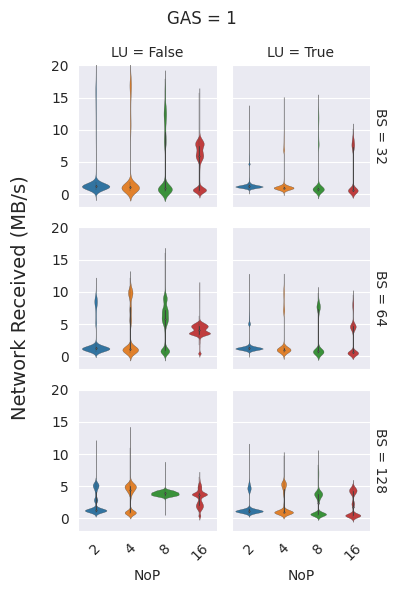

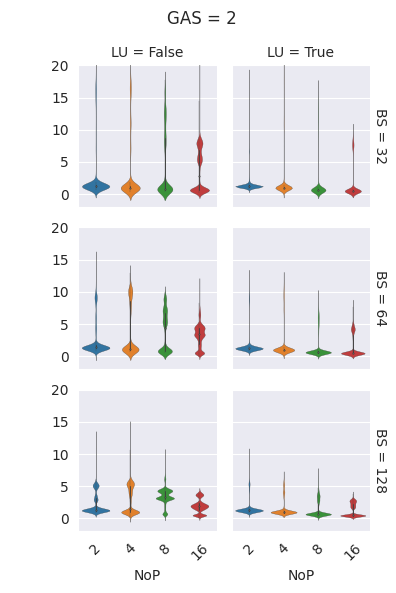

In [22]:
from viz import viz_column_all
viz_column_all("06", filename, "bandwidth/net_recv_sys_bandwidth_mbs", ylabel="Network Received (MB/s)", xaxislabel="NoP", is_nop=True, ylim=(-2, 20))

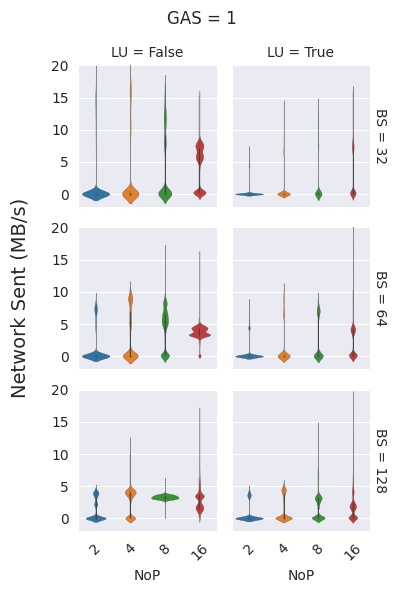

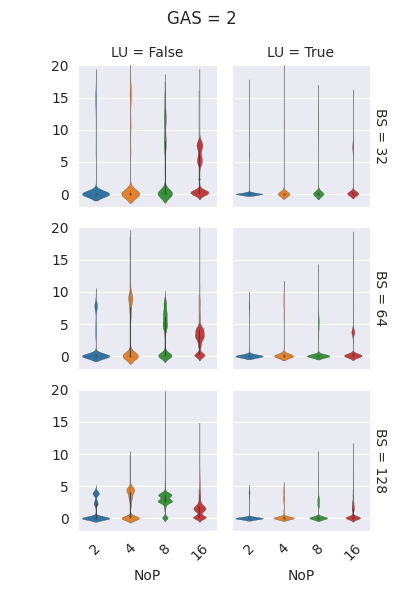

In [23]:
from viz import viz_column_all
viz_column_all("06", filename, "bandwidth/net_sent_sys_bandwidth_mbs", ylabel="Network Sent (MB/s)", is_nop=True, xaxislabel="NoP", ylim=(-2, 20))

In [70]:
import itertools
import pandas as pd

group_by = ["number_of_nodes", "batch_size_per_step", "optimizer_params.lr", "gradient_accumulation_steps", "use_local_updates"]
ascending = [True, False, True, True, True]
describe_cols = ["train/data_load_s", "train/model_forward_s", "train/model_backward_only_s", "train/model_opt_s"]

summary_data = pd.read_csv(os.path.abspath('') + f"/summary-{filename}", usecols=[*group_by, *describe_cols])

summary_data = summary_data.groupby(by=group_by)[describe_cols].median().reset_index()

summary_data = summary_data.sort_values(group_by, ascending=ascending).reset_index(drop=True)

subset = summary_data[(summary_data["number_of_nodes"] == 16) & (summary_data["batch_size_per_step"] == 128) & (summary_data["gradient_accumulation_steps"] == 1) & (summary_data["use_local_updates"] == True)]

subset[["train/data_load_s", "train/model_forward_s", "train/model_backward_only_s", "train/model_opt_s"]]

,train/data_load_s,train/model_forward_s,train/model_backward_only_s,train/model_opt_s
109,5.966817,10.283200,18.153388,0.081747
113,6.937189,10.827398,18.618882,0.064104
117,6.631455,10.920770,19.381440,0.080865


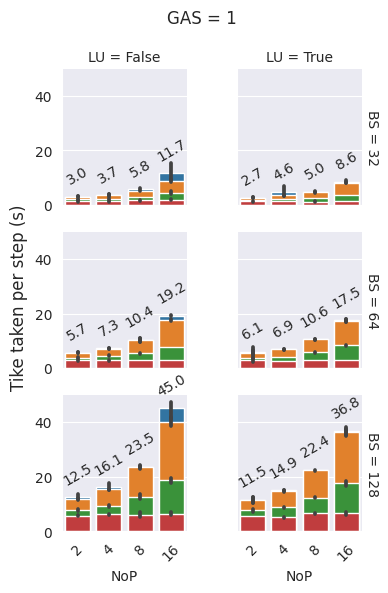

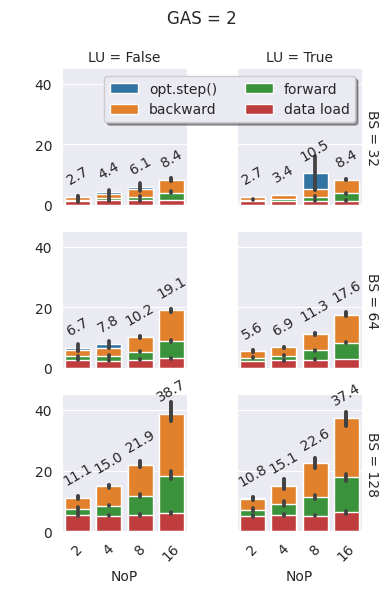

In [21]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt

group_by = ["number_of_nodes", "batch_size_per_step", "optimizer_params.lr", "gradient_accumulation_steps", "use_local_updates"]
ascending = [True, False, True, True, True]
describe_cols = ["train/data_load_s", "train/model_forward_s", "train/model_backward_only_s", "train/model_opt_s"]

summary_data = pd.read_csv(os.path.abspath('') + f"/summary-{filename}", usecols=[*group_by, *describe_cols])

summary_data = summary_data.groupby(by=group_by)[describe_cols].describe().reset_index()

summary_data = summary_data.sort_values(group_by, ascending=ascending).reset_index(drop=True)

def stacked_bar(x, color, data, **kwargs):
    palette = itertools.cycle(sns.color_palette("tab10"))

    base_labels = data["number_of_nodes"].unique()
    data_cumulated_column = data["train/data_load_s"]["mean"]
    data_labels = "data load"
    forward_cumulated_column = data_cumulated_column + data["train/model_forward_s"]["mean"]
    forward_labels = "forward"
    backward_cumulated_column = forward_cumulated_column + data["train/model_backward_only_s"]["mean"]
    backward_labels = "backward"
    opt_cumulated_column = backward_cumulated_column + data["train/model_opt_s"]["mean"]
    opt_labels = "opt.step()"

    sns.barplot(data, x=x, y=opt_cumulated_column, label=opt_labels, color=next(palette), **kwargs)
    sns.barplot(data, x=x, y=backward_cumulated_column, label=backward_labels, color=next(palette), **kwargs)
    sns.barplot(data, x=x, y=forward_cumulated_column, label=forward_labels, color=next(palette), **kwargs)
    ax = sns.barplot(data, x=x, y=data_cumulated_column, label=data_labels, color=next(palette), **kwargs)
    for i, container in enumerate(ax.containers):
        if i % 4 == 0:
            ax.bar_label(container, fmt="%.1f", rotation=30, padding=7)

for gas in [1, 2]:
    data_gas = summary_data[summary_data["gradient_accumulation_steps"] == gas]
    g1 = sns.FacetGrid(data_gas, col="use_local_updates", row="batch_size_per_step", height=2, margin_titles=True, gridspec_kws={"wspace": 0.4, "hspace": 0.2})
    g1.figure.suptitle(f"GAS = {gas}")
    g1.set_xticklabels(rotation=45)

    g2 = g1.map_dataframe(
        stacked_bar,
        x="number_of_nodes",
        dodge=False,
        order=data_gas["number_of_nodes"].unique(),
        linewidth=1,
    )

    g1.set_titles(col_template="LU = {col_name}", row_template="BS = {row_name}")
    g1.set_xlabels("NoP")
    g1.set_ylabels("")
    g1.figure.subplots_adjust(left=0.15)
    if gas == 1:
        g1.figure.supylabel("Tike taken per step (s)", fontsize=12)
    if gas == 2:
        g1.figure.supylabel(" ", fontsize=12)
        ax = plt.gca()
        ax.legend(bbox_to_anchor=(1, 3.4), ncol=2, fancybox=True, shadow=True, prop={"size": 10})
    g1.tight_layout()
    g1.figure.savefig(f"../../figures/06_barplot-times_gas-{gas}_{filename.replace('.csv', '.pdf')}", bbox_inches='tight')
    plt.show()

